## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: [Mod4_Blog](https://renjmindy.github.io/diagnosis_of_covid-19_alike_viral_pneumonia)
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [2]:
new_dir = 'split/'

train_folder = os.path.join(new_dir, 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join(new_dir, 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join(new_dir, 'validation')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [3]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    train_folder, 
    # All images will be resized to 150x150
    target_size=(210, 210), batch_size = 4685)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 4685 images belonging to 2 classes.


In [4]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder, 
    target_size=(210, 210), batch_size = 585)
    #,
    #class_mode='binary')

validating data:
Found 586 images belonging to 2 classes.


In [5]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder, 
    target_size=(210, 210), batch_size = 585)
    #,
    #class_mode='binary') 

testing data:
Found 585 images belonging to 2 classes.


In [6]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [7]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))

In [8]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Designing CNN Model w/ Early Stopping

Now it's time to design your CNN using Keras! Remember a few things when doing this: 

- You should alternate convolutional and pooling layers
- You should have later layers have a larger number of parameters in order to detect more abstract patterns
- Add some final dense layers to add a classifier to the convolutional base 
- Compile this model 

In [9]:
# Your code here; design and compile the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(210, 210, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

* Import `EarlyStopping` and `ModelCheckpoint` from keras.callbacks
* Define a list, `early_stopping`:
    * Monitor `val_loss` and continue training for 10 epochs before stopping
    * Save the best model while monitoring `val_loss`

In [10]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='./cnn1_chest_xray_ALL_data_BestModel_'+str(date.today())+'.h5', 
                                  monitor='val_loss', save_best_only=True)]

In [11]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

## Training and Evaluating the Model

Remember that training deep networks is resource intensive: depending on the size of the data, even a CNN with 3-4 successive convolutional and pooling layers is apt to take hours to train on a high-end laptop. Using 30 epochs and 8 layers (alternating between convolutional and pooling), my model took about 14 hours to run on a 9 years old macbook pro (Late 2011, macOS High Sierra, v.10.13.6). That is, I set my model to run the training epochs overnight.  

In [12]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start = datetime.datetime.now()
print('program starts, current time:')
print(start)
history = model.fit(train_images, train_y, epochs=100, callbacks=early_stopping, batch_size=100, validation_data=(val_images, val_y))
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2020-09-21 19:04:06.185686
Epoch 1/100
47/47 [==============================] - 941s 20s/step - loss: 0.5636 - accuracy: 0.7300 - val_loss: 0.5239 - val_accuracy: 0.7299
Epoch 2/100
47/47 [==============================] - 950s 20s/step - loss: 0.4605 - accuracy: 0.7797 - val_loss: 0.4003 - val_accuracy: 0.7983
Epoch 3/100
47/47 [==============================] - 936s 20s/step - loss: 0.3627 - accuracy: 0.8551 - val_loss: 0.3190 - val_accuracy: 0.9026
Epoch 4/100
47/47 [==============================] - 940s 20s/step - loss: 0.3032 - accuracy: 0.8798 - val_loss: 0.2898 - val_accuracy: 0.8769
Epoch 5/100
47/47 [==============================] - 930s 20s/step - loss: 0.2699 - accuracy: 0.8952 - val_loss: 0.2598 - val_accuracy: 0.9094
Epoch 6/100
47/47 [==============================] - 936s 20s/step - loss: 0.2481 - accuracy: 0.8997 - val_loss: 0.2382 - val_accuracy: 0.9128
Epoch 7/100
47/47 [==============================] - 1205s 26s/step - loss: 0.2284 - 

47/47 [==============================] - 937s 20s/step - loss: 0.0795 - accuracy: 0.9725 - val_loss: 0.1461 - val_accuracy: 0.9436
Epoch 58/100
47/47 [==============================] - 941s 20s/step - loss: 0.0776 - accuracy: 0.9740 - val_loss: 0.1634 - val_accuracy: 0.9385
Epoch 59/100
47/47 [==============================] - 938s 20s/step - loss: 0.0759 - accuracy: 0.9729 - val_loss: 0.1460 - val_accuracy: 0.9402
Epoch 60/100
47/47 [==============================] - 950s 20s/step - loss: 0.0773 - accuracy: 0.9720 - val_loss: 0.1540 - val_accuracy: 0.9436
Epoch 61/100
47/47 [==============================] - 1026s 22s/step - loss: 0.0746 - accuracy: 0.9742 - val_loss: 0.1484 - val_accuracy: 0.9419
Epoch 62/100
47/47 [==============================] - 1004s 21s/step - loss: 0.0750 - accuracy: 0.9746 - val_loss: 0.1488 - val_accuracy: 0.9368
Epoch 63/100
47/47 [==============================] - 1021s 22s/step - loss: 0.0721 - accuracy: 0.9737 - val_loss: 0.1791 - val_accuracy: 0.9402
Ep

## CNN Model Evaluation

Now use the test set to perform an evaluation on the model of choice. 

In [15]:
# Load the best (saved) model
from keras.models import load_model
saved_model = load_model('./cnn1_chest_xray_ALL_data_BestModel_2020-09-21.h5')

In [16]:
results_train = model.evaluate(train_images, train_y)

147/147 [==============================] - 201s 1s/step - loss: 0.0706 - accuracy: 0.9755


In [17]:
results_test = model.evaluate(test_images, test_y)

19/19 [==============================] - 17s 908ms/step - loss: 0.0801 - accuracy: 0.9744


In [19]:
best_results_train = saved_model.evaluate(train_images, train_y)

147/147 [==============================] - 278s 2s/step - loss: 0.0737 - accuracy: 0.9750


In [20]:
best_results_test = saved_model.evaluate(test_images, test_y)

19/19 [==============================] - 32s 2s/step - loss: 0.0819 - accuracy: 0.9692


In [21]:
results_train

[0.07064909487962723, 0.9754535555839539]

In [22]:
results_test

[0.08005109429359436, 0.9743589758872986]

In [23]:
best_results_train

[0.07371962070465088, 0.9750266671180725]

In [24]:
best_results_test

[0.08194692432880402, 0.9692307710647583]

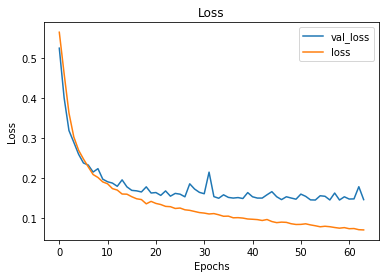

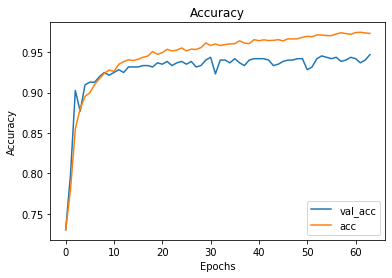

In [25]:
visualize_training_results(history)

## Saving history in CSV

In [26]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'cnn1_chest_xray_ALL_data_BestModel'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)